<a href="https://colab.research.google.com/github/RSDUNN0809/hr_analytics_case_study/blob/main/TreeBasedModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Attrition with Tree-based Methods

### Stephen Kuc and Ryan Dunn

### Connect to data sources and import libraries for modeling

In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.6 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np
import sqlite3
import csv

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import linear_model, tree, ensemble
import xgboost as xgb
from sklearn.svm import SVC # if we wnated a linear SVM 
from dmba import classificationSummary
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from scipy.stats import uniform, randint

from imblearn.over_sampling import SMOTE

import pydotplus 
from IPython.display import Image
import matplotlib.pyplot as plt

# Turn off warnings for ease of viewing
import warnings
warnings.filterwarnings("ignore")

# Set option to see all columns in output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

## Connecting to SQL database to bring in transformed_data table and non_transformed

In [4]:
## Transformed Data

# Connect to the database
conn = sqlite3.connect('/content/drive/My Drive/MS-ADS Capstone Project/data/hr_case_study.db')

##### Query general_data table ##### 
# Create cursor object and query table
cursor = conn.cursor()
cursor.execute('SELECT * FROM transformed_data AS d')

# Identify the column names for dataframe
col_names = [desc[0] for desc in cursor.description]

# Fetch all rows from the query and store in dataframe
rows = cursor.fetchall()
transformed_sql= pd.DataFrame(rows, columns = col_names)

# Close the cursor and connection objects
cursor.close()
conn.close()

In [28]:
transformed_sql.head()

index  Unnamed: 0  Education  EmployeeID  JobLevel  NumCompaniesWorked  \
0      0           0       0.25           1         1                 1.0   
1      1           1       0.00           2         1                 0.0   
2      2           2       0.75           3         4                 1.0   
3      3           3       1.00           4         3                 3.0   
4      4           4       0.00           5         1                 4.0   

   JobInvolvement  PerformanceRating  EnvironmentSatisfaction  \
0        0.666667                0.0                 0.666667   
1        0.333333                1.0                 0.666667   
2        0.666667                0.0                 0.333333   
3        0.333333                0.0                 1.000000   
4        0.666667                0.0                 1.000000   

   JobSatisfaction  WorkLifeBalance  time_id                  mean_time  \
0         1.000000         0.333333        1  0 days 07:22:26.896551724   
1         0.333333         1.000000        2  0 days 07:43:03.813559322   
2         0.333333         0.000000        3  0 days 07:00:48.595041322   
3         1.000000         0.666667        4  0 days 07:11:36.510638298   
4         0.000000         0.666667        5  0 days 08:00:22.530612245   

       median_time         max_time  num_times_over_9hours  \
0  0 days 07:23:00  0 days 07:57:00                      0   
1  0 days 07:43:00  0 days 08:34:00                      0   
2  0 days 06:59:00  0 days 07:59:00                      0   
3  0 days 07:11:00  0 days 07:53:00                      0   
4  0 days 07:58:00  0 days 08:50:00                      0   

   num_times_over_11hours  %_under_8  %_over_9  %_over_11  \
0                       0        1.0       0.0        0.0   
1                       0        1.0       0.0        0.0   
2                       0        1.0       0.0        0.0   
3                       0        1.0       0.0        0.0   
4                       0        1.0       0.0        0.0   

   clipped_TrainingTimesLastYear  clipped_NumCompaniesWorked   log_Age  \
0                           1.00                       0.125  0.863147   
1                           0.50                       0.000  0.446915   
2                           0.25                       0.125  0.473296   
3                           1.00                       0.375  0.616513   
4                           0.25                       0.500  0.473296   

   log_StockOptionLevel  log_YearsSinceLastPromotion  log_TotalWorkingYears  \
0              0.000000                         0.00               0.186652   
1              0.301030                         0.25               0.482489   
2              0.602060                         0.00               0.482489   
3              0.602060                         0.75               0.591674   
4              0.477121                         0.00               0.524000   

   log_YearsAtCompany  log_MonthlyIncome  log_PercentSalaryHike  \
0            0.186652           0.858755               0.000000   
1            0.482489           0.476600               0.896477   
2            0.482489           0.988573               0.372072   
3            0.591674           0.706394               0.000000   
4            0.524000           0.281920               0.103523   

   log_DistanceFromHome  log_clipped_YearsWithCurrentManager  \
0              0.462607                             0.000000   
1              0.629511                             0.671188   
2              0.811368                             0.578130   
3              0.149726                             0.747222   
4              0.629511                             0.671188   

   log_clipped_num_times_less_8hours  log_total_days  \
0                           0.992462        0.847162   
1                           0.959652        0.791635   
2                           1.000000        0.859920   
3                         

In [5]:
cols_to_keep = ['Attrition_Yes','Education','JobLevel','clipped_NumCompaniesWorked','JobInvolvement','PerformanceRating','EnvironmentSatisfaction',
                'JobSatisfaction','WorkLifeBalance','%_over_11','clipped_TrainingTimesLastYear','log_Age','log_StockOptionLevel','log_YearsSinceLastPromotion',
                'log_TotalWorkingYears','log_YearsAtCompany','log_MonthlyIncome','log_PercentSalaryHike','log_DistanceFromHome','log_clipped_YearsWithCurrentManager',
                'BusinessTravel_Travel_Frequently','Department_Research & Development','Department_Sales','JobRole_Manager','JobRole_Sales Representative',
                'EducationField_Technical Degree']

model_df = transformed_sql[cols_to_keep]

model_df.head()

Attrition_Yes  Education  JobLevel  clipped_NumCompaniesWorked  \
0              0       0.25         1                       0.125   
1              1       0.00         1                       0.000   
2              0       0.75         4                       0.125   
3              0       1.00         3                       0.375   
4              0       0.00         1                       0.500   

   JobInvolvement  PerformanceRating  EnvironmentSatisfaction  \
0        0.666667                0.0                 0.666667   
1        0.333333                1.0                 0.666667   
2        0.666667                0.0                 0.333333   
3        0.333333                0.0                 1.000000   
4        0.666667                0.0                 1.000000   

   JobSatisfaction  WorkLifeBalance  %_over_11  clipped_TrainingTimesLastYear  \
0         1.000000         0.333333        0.0                           1.00   
1         0.333333         1.000000        0.0                           0.50   
2         0.333333         0.000000        0.0                           0.25   
3         1.000000         0.666667        0.0                           1.00   
4         0.000000         0.666667        0.0                           0.25   

    log_Age  log_StockOptionLevel  log_YearsSinceLastPromotion  \
0  0.863147              0.000000                         0.00   
1  0.446915              0.301030                         0.25   
2  0.473296              0.602060                         0.00   
3  0.616513              0.602060                         0.75   
4  0.473296              0.477121                         0.00   

   log_TotalWorkingYears  log_YearsAtCompany  log_MonthlyIncome  \
0               0.186652            0.186652           0.858755   
1               0.482489            0.482489           0.476600   
2               0.482489            0.482489           0.988573   
3               0.591674            0.591674           0.706394   
4               0.524000            0.524000           0.281920   

   log_PercentSalaryHike  log_DistanceFromHome  \
0               0.000000              0.462607   
1               0.896477              0.629511   
2               0.372072              0.811368   
3               0.000000              0.149726   
4               0.103523              0.629511   

   log_clipped_YearsWithCurrentManager  BusinessTravel_Travel_Frequently  \
0                             0.000000                                 0   
1                             0.671188                                 1   
2                             0.578130                                 1   
3                             0.747222                                 0   
4                             0.671188                                 0   

   Department_Research & Development  Department_Sales  JobRole_Manager  \
0                                  0                 1                0   
1                                  1                 0                0   
2                                  1                 0                0   
3                                  1                 0                0   
4                                  1                 0                0   

   JobRole_Sales Representative  EducationField_Technical Degree  
0                             0                                0  
1                             0                                0  
2                             0                                0  
3                             0                                0  
4                             0                                0

## Splitting and Balancing the Data

In [6]:
# Assign the independent and dependent variables
y = model_df['Attrition_Yes']
X = model_df.drop(columns = ['Attrition_Yes'])

# partitioning data into 90% train and 10% test, and then will further split for validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, random_state = 12345)



In [7]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree

smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train) # X_smt and y_smt will be used in modeling if concerns around balanced data

y_train_smt.value_counts()

0    2668
1    2668
Name: Attrition_Yes, dtype: int64

In [10]:
### Modeling Attrition with Tree-based Method

# generating a basic tree with maximum depth of 4

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)

clf = clf.fit(X_train, y_train)

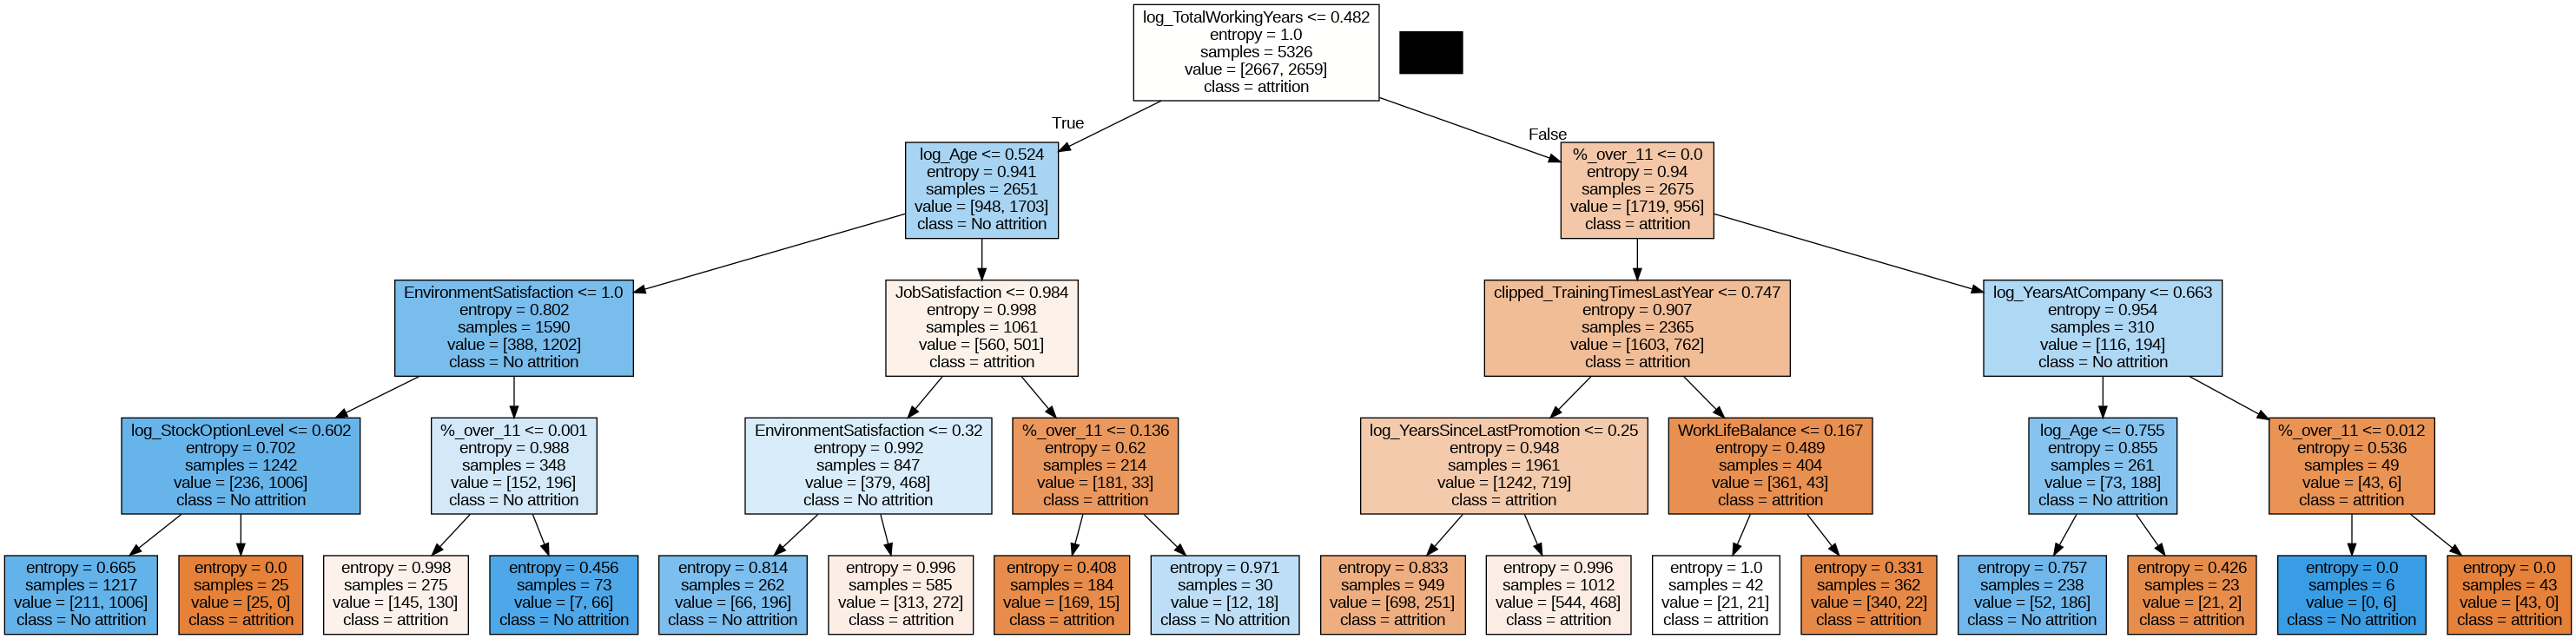

In [11]:
# installed graphviz & pydotplus
# using to plot the resulting decision tree after training the clasifier

import pydotplus 
from IPython.display import Image

dot_data = tree.export_graphviz(clf, feature_names= X_train.columns, class_names=['attrition','No attrition'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())



In [28]:
## testing this on validation set

y_pred = clf.predict(X_valid)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_valid, y_pred)))

Accuracy on validation data is 0.68


In [29]:
# Getting confusion Matrix

print(classificationSummary(y_valid, y_pred))

Confusion Matrix (Accuracy 0.6824)

       Prediction
Actual   0   1
     0 549 103
     1 320 360
None


In [30]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       652
           1       0.78      0.53      0.63       680

    accuracy                           0.68      1332
   macro avg       0.70      0.69      0.68      1332
weighted avg       0.71      0.68      0.67      1332



## Tuning Decision Tree

In [55]:
# decision tree

dt_results = []
criterion = ["gini", "entropy", "log_loss"]


for x in criterion:
    for y in range(1,15,1):
        dt = tree.DecisionTreeClassifier(criterion = x, max_depth = y, random_state = 1).fit(X_train, y_train)
        valid_preds = dt.predict(X_valid)
        dt_results.append({'criterion': x, 'max_depth': y,
                           'accuracy': accuracy_score(y_valid, valid_preds), 
                      'precision': precision_score(y_valid, valid_preds),
                           'recall': recall_score(y_valid, valid_preds),
                      'f1_score': f1_score(y_valid, valid_preds)})
    

# Convert results to a pandas data frame
dt_results = pd.DataFrame(dt_results)


In [56]:
print(dt_results)

   criterion  max_depth  accuracy  precision    recall  f1_score
0       gini          1  0.827456   0.000000  0.000000  0.000000
1       gini          2  0.819899   0.440000  0.160584  0.235294
2       gini          3  0.819899   0.440000  0.160584  0.235294
3       gini          4  0.833753   0.537313  0.262774  0.352941
4       gini          5  0.865239   0.826087  0.277372  0.415301
5       gini          6  0.876574   0.809524  0.372263  0.510000
6       gini          7  0.875315   0.737500  0.430657  0.543779
7       gini          8  0.886650   0.742268  0.525547  0.615385
8       gini          9  0.903023   0.777778  0.613139  0.685714
9       gini         10  0.928212   0.857143  0.700730  0.771084
10      gini         11  0.938287   0.872881  0.751825  0.807843
11      gini         12  0.958438   0.900000  0.854015  0.876404
12      gini         13  0.965995   0.923077  0.875912  0.898876
13      gini         14  0.971033   0.919118  0.912409  0.915751
14   entropy          1  

In [41]:
# show accuracy by depth
plt.plot(dt_results['max_depth'], dt_results.accuracy, linestyle='-', label = "accuracy")
plt.plot(dt_results['max_depth'], dt_results.recall, linestyle=':', c='red', label = "recall")
plt.plot(dt_results['max_depth'], dt_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.title('Number of estimators vs. metrics \n In validation set for decision tree \n Using Entropy Loss')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Metrics score')

plt.show()

(For some reason the above is not displaying.)

It doesn't seem the loss function has an affect on its accuracy. All seem to reach 90%+ accuracy and F1 score around max depth of 10-11.

False negatives are more important to limit in this problem as opposed to false positives; thus, we should try to maximize the recall. 

It seems the best option , with trying not to over-fit, is with entropy at max_depth of 10.

In [13]:
# training DT with 'optimal' parameters on all data and testing

# partitioning data into 80% train and 20% test

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size = .2, random_state = 12345)

In [ ]:
y_train_smt

In [14]:
# DT

clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10)

clf = clf.fit(X_train_, y_train_)

## testing this on test set

y_pred_ = clf.predict(X_test_)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_test_, y_pred_)))
# Getting confusion Matrix

print(classificationSummary(y_test_, y_pred_))
print(classification_report(y_test_, y_pred_))

Accuracy on validation data is 0.88
Confusion Matrix (Accuracy 0.8797)

       Prediction
Actual   0   1
     0 653 140
     1  38 649
None
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       793
           1       0.82      0.94      0.88       687

    accuracy                           0.88      1480
   macro avg       0.88      0.88      0.88      1480
weighted avg       0.89      0.88      0.88      1480



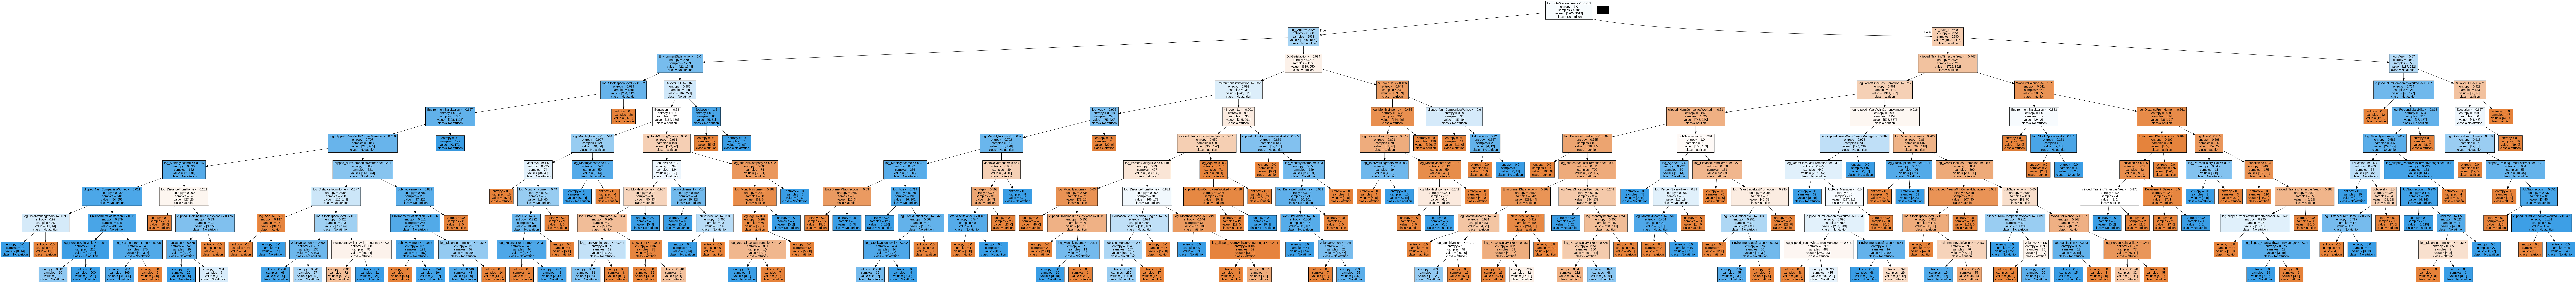

In [15]:
dot_data = tree.export_graphviz(clf, feature_names= X_train.columns, class_names=['attrition','No attrition'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [25]:
# finding feature importance for decision tree

importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.classes_], axis=0)
rf_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
rf_df = rf_df.sort_values('importance', ascending = False)
print(rf_df)

                                feature  importance  std
15                    log_MonthlyIncome    0.104204  0.0
13                log_TotalWorkingYears    0.091703  0.0
10                              log_Age    0.088093  0.0
5               EnvironmentSatisfaction    0.083232  0.0
17                 log_DistanceFromHome    0.081368  0.0
18  log_clipped_YearsWithCurrentManager    0.075052  0.0
12          log_YearsSinceLastPromotion    0.058172  0.0
6                       JobSatisfaction    0.053696  0.0
2            clipped_NumCompaniesWorked    0.051732  0.0
9         clipped_TrainingTimesLastYear    0.050924  0.0
8                             %_over_11    0.049572  0.0
11                 log_StockOptionLevel    0.043071  0.0
16                log_PercentSalaryHike    0.038716  0.0
1                              JobLevel    0.029956  0.0
0                             Education    0.027993  0.0
3                        JobInvolvement    0.022402  0.0
7                       WorkLif

### Modeling Random Forest

In [48]:
# random forest tuning hyperparameters with Grid Search
# Took very long to tune, lessened parameters; went with entropy as criterion based on DT results

grid_parameters = { 
    'n_estimators': range(200,1001,100),
    'max_depth' : range(4,12,1)}


rf_search = GridSearchCV(ensemble.RandomForestClassifier(random_state=1234, criterion = 'entropy', max_features = 'sqrt'), grid_parameters, cv= 5)
rf_search = rf_search.fit(X_train_smt, y_train_smt)

# saving best parameters
rf_clf = rf_search.best_estimator_ 

In [50]:
rf_clf

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=300,
                       random_state=1234)

Per the validation, the 'optimal' parameters seem to be max_depth = 11 and n_estimators = 300.

In [59]:
rf = ensemble.RandomForestClassifier(n_estimators = 300, max_depth = 11, random_state = 1234).fit(X_train_smt, y_train_smt)

## testing this on test set

y_pred_rf = rf.predict(X_valid)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_valid, y_pred_rf)))
# Getting confusion Matrix

print(classificationSummary(y_valid, y_pred_rf))
print(classification_report(y_valid, y_pred_rf))

Accuracy on validation data is 0.97
Confusion Matrix (Accuracy 0.9685)

       Prediction
Actual   0   1
     0 645  12
     1  13 124
None
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       657
           1       0.91      0.91      0.91       137

    accuracy                           0.97       794
   macro avg       0.95      0.94      0.94       794
weighted avg       0.97      0.97      0.97       794



In [58]:
# trying with a different max_depth

rf = ensemble.RandomForestClassifier(n_estimators = 300, max_depth = 8, random_state = 1234).fit(X_train_smt, y_train_smt)

## testing this on test set

y_pred_rf = rf.predict(X_valid)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_valid, y_pred_rf)))
# Getting confusion Matrix

print(classificationSummary(y_valid, y_pred_rf))
print(classification_report(y_valid, y_pred_rf))

Accuracy on validation data is 0.90
Confusion Matrix (Accuracy 0.9018)

       Prediction
Actual   0   1
     0 622  35
     1  43  94
None
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       657
           1       0.73      0.69      0.71       137

    accuracy                           0.90       794
   macro avg       0.83      0.82      0.82       794
weighted avg       0.90      0.90      0.90       794



These numbers seem to point to overfitting; let's take a closer look at areas like the gridsearch results and feature importance

In [60]:
# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
rf_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
rf_df = rf_df.sort_values('importance', ascending = False)
print(rf_df)


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(25)

ax = rf_df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('Feature')
plt.show()

                                feature  importance       std
10                              log_Age    0.092079  0.026042
14                   log_YearsAtCompany    0.084826  0.053799
13                log_TotalWorkingYears    0.081827  0.054251
18  log_clipped_YearsWithCurrentManager    0.071845  0.044593
5               EnvironmentSatisfaction    0.056544  0.023805
15                    log_MonthlyIncome    0.055371  0.016721
6                       JobSatisfaction    0.055035  0.026821
17                 log_DistanceFromHome    0.051800  0.016078
12          log_YearsSinceLastPromotion    0.051287  0.023750
2            clipped_NumCompaniesWorked    0.051258  0.018939
9         clipped_TrainingTimesLastYear    0.050558  0.022087
16                log_PercentSalaryHike    0.042206  0.013703
0                             Education    0.035717  0.017789
11                 log_StockOptionLevel    0.035552  0.019455
3                        JobInvolvement    0.035214  0.017778
8       

In [27]:
model_df[['log_Age', 'log_YearsAtCompany', 'log_TotalWorkingYears', 'log_clipped_YearsWithCurrentManager', 'JobSatisfaction', 'EnvironmentSatisfaction', 'Attrition_Yes']].corr()

log_Age  log_YearsAtCompany  \
log_Age                              1.000000            0.297130   
log_YearsAtCompany                   0.297130            1.000000   
log_TotalWorkingYears                0.297111            0.999997   
log_clipped_YearsWithCurrentManager  0.196486            0.821163   
JobSatisfaction                     -0.004266            0.008358   
EnvironmentSatisfaction              0.009496            0.007106   
Attrition_Yes                       -0.180242           -0.198467   

                                     log_TotalWorkingYears  \
log_Age                                           0.297111   
log_YearsAtCompany                                0.999997   
log_TotalWorkingYears                             1.000000   
log_clipped_YearsWithCurrentManager               0.821145   
JobSatisfaction                                   0.008344   
EnvironmentSatisfaction                           0.007088   
Attrition_Yes                                    -0.198449   

                                     log_clipped_YearsWithCurrentManager  \
log_Age                                                         0.196486   
log_YearsAtCompany                                              0.821163   
log_TotalWorkingYears                                           0.821145   
log_clipped_YearsWithCurrentManager                             1.000000   
JobSatisfaction                                                -0.012252   
EnvironmentSatisfaction                                         0.001693   
Attrition_Yes                                                  -0.190233   

                                     JobSatisfaction  EnvironmentSatisfaction  \
log_Age                                    -0.004266                 0.009496   
log_YearsAtCompany                          0.008358                 0.007106   
log_TotalWorkingYears                       0.008344                 0.007088   
log_clipped_YearsWithCurrentManager        -0.012252                 0.001693   
JobSatisfaction                             1.000000                -0.005403   
EnvironmentSatisfaction                    -0.005403                 1.000000   
Attrition_Yes                              -0.102917                -0.101761   

                                     Attrition_Yes  
log_Age                                  -0.180242  
log_YearsAtCompany                       -0.198467  
log_TotalWorkingYears                    -0.198449  
log_clipped_YearsWithCurrentManager      -0.190233  
JobSatisfaction                          -0.102917  
EnvironmentSatisfaction                  -0.101761  
Attrition_Yes                             1.000000

There is some multi-collinearity between features near the top, all having to do with age or time at the company, and this supports that there may have been overfitting.

There is an opportunity to itereate each of these, with considerably less features for each, as well as trying with different data balancing techniques to limit overfitting concerns.

## Feature Selection and Model Iteration/Re train

In [31]:
model_df.columns

Index(['Attrition_Yes', 'Education', 'JobLevel', 'clipped_NumCompaniesWorked',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', '%_over_11',
       'clipped_TrainingTimesLastYear', 'log_Age', 'log_StockOptionLevel',
       'log_YearsSinceLastPromotion', 'log_TotalWorkingYears',
       'log_YearsAtCompany', 'log_MonthlyIncome', 'log_PercentSalaryHike',
       'log_DistanceFromHome', 'log_clipped_YearsWithCurrentManager',
       'BusinessTravel_Travel_Frequently', 'Department_Research & Development',
       'Department_Sales', 'JobRole_Manager', 'JobRole_Sales Representative',
       'EducationField_Technical Degree', 'MaritalStatus_Single',
       'WorkLifeBalance'],
      dtype='object')

In [8]:
## Getting rid of features w/ high multi-collinearity and low importance in both DT and RF

cols_drop = ['log_YearsAtCompany', 'log_TotalWorkingYears', 'JobRole_Sales Representative', 'PerformanceRating', 'JobRole_Manager', 'Department_Research & Development']

model_df_small = model_df.drop(cols_drop, axis = 1)



In [9]:
# Assign the independent and dependent variables
y_s = model_df_small['Attrition_Yes']
X_s = model_df_small.drop(columns = ['Attrition_Yes'])


# partitioning data into 90% train and 10% test, and then will further split for validation


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = .1, random_state = 12345)


# using 80 / 20 split for train and validation set


X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = .2, random_state = 12345)


In [10]:
# Balancing data
# Using SMOTE so we don't lose data and synthetically create new data points
# may still result in overfitting to some degree


smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt_s, y_train_smt_s = smote.fit_resample(X_train_s, y_train_s) # X_smt and y_smt will be used in modeling if concerns around balanced data


y_train_smt_s.value_counts()

0    2668
1    2668
Name: Attrition_Yes, dtype: int64

In [70]:
# decision tree

dt_results = []

for y in range(1,20,1):
        dt = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = y, random_state = 1).fit(X_train_smt_s, y_train_smt_s)
        valid_preds = dt.predict(X_valid_s)
        dt_results.append({'criterion': "entropy", 'max_depth': y,
                           'accuracy': accuracy_score(y_valid_s, valid_preds), 
                      'precision': precision_score(y_valid_s, valid_preds),
                           'recall': recall_score(y_valid_s, valid_preds),
                      'f1_score': f1_score(y_valid_s, valid_preds)})
    

# Convert results to a pandas data frame
dt_results_small = pd.DataFrame(dt_results)

In [71]:
print(dt_results_small)

   criterion  max_depth  accuracy  precision    recall  f1_score
0    entropy          1  0.714106   0.260638  0.357664  0.301538
1    entropy          2  0.714106   0.260638  0.357664  0.301538
2    entropy          3  0.765743   0.323741  0.328467  0.326087
3    entropy          4  0.782116   0.354839  0.321168  0.337165
4    entropy          5  0.724181   0.321739  0.540146  0.403270
5    entropy          6  0.764484   0.393162  0.671533  0.495957
6    entropy          7  0.826196   0.497110  0.627737  0.554839
7    entropy          8  0.836272   0.522293  0.598540  0.557823
8    entropy          9  0.867758   0.596386  0.722628  0.653465
9    entropy         10  0.879093   0.639456  0.686131  0.661972
10   entropy         11  0.866499   0.582888  0.795620  0.672840
11   entropy         12  0.901763   0.672515  0.839416  0.746753
12   entropy         13  0.900504   0.652632  0.905109  0.758410
13   entropy         14  0.916877   0.693989  0.927007  0.793750
14   entropy         15  

In [72]:
# using max_depth of 14, we'll re-train this

dt = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 14, random_state = 1).fit(X_train_smt_s, y_train_smt_s)

# and use on test set

y_preds = dt.predict(X_test_s)

print('accuracy: ', accuracy_score(y_test_s, y_preds), 
                      'precision: ', precision_score(y_test_s, y_preds),
                           'recall: ', recall_score(y_test_s, y_preds),
                      'f1_score: ', f1_score(y_test_s, y_preds))

accuracy:  0.9251700680272109 precision:  0.7023809523809523 recall:  0.8805970149253731 f1_score:  0.7814569536423842


In [73]:
print(classificationSummary(y_test_s, y_preds))
print(classification_report(y_test_s, y_preds))

Confusion Matrix (Accuracy 0.9252)

       Prediction
Actual   0   1
     0 349  25
     1   8  59
None
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       374
           1       0.70      0.88      0.78        67

    accuracy                           0.93       441
   macro avg       0.84      0.91      0.87       441
weighted avg       0.94      0.93      0.93       441



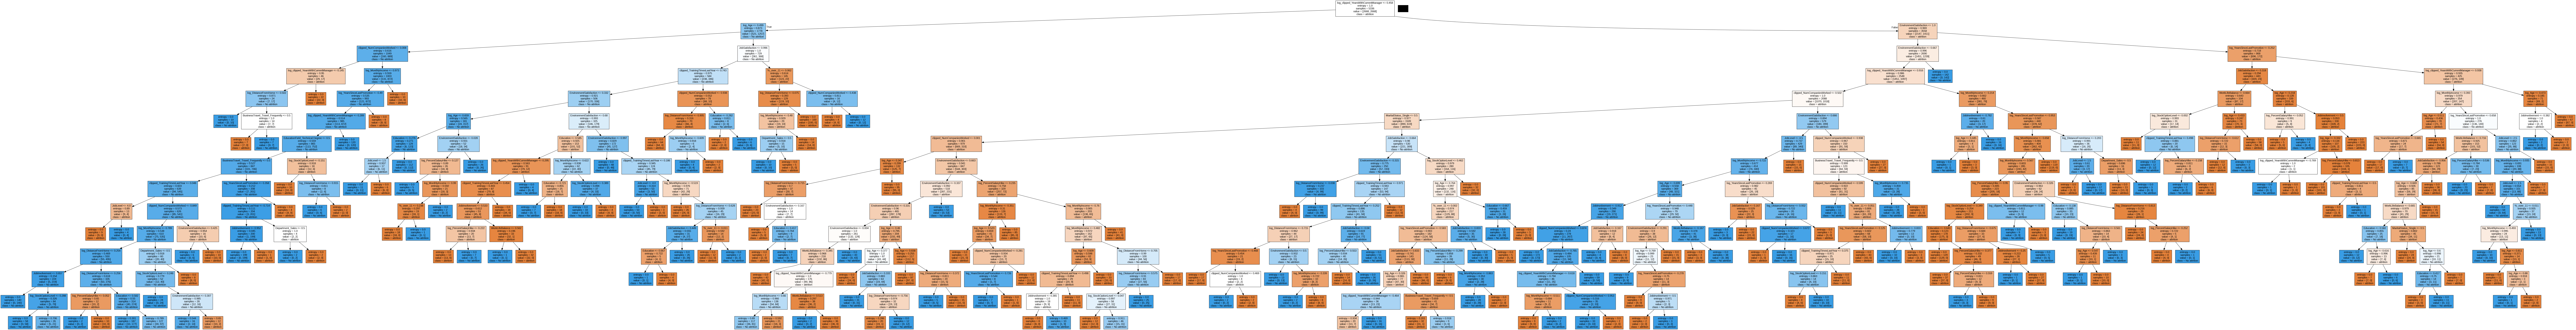

In [74]:
dot_data = tree.export_graphviz(dt, feature_names= X_train.columns, class_names=['attrition','No attrition'], filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

In [75]:
# finding feature importance for decision tree

importances = dt.feature_importances_
std = np.std([dt.feature_importances_ for tree in dt.classes_], axis=0)
dt_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
dt_df = dt_df.sort_values('importance', ascending = False)
print(dt_df)

                                feature  importance  std
4               EnvironmentSatisfaction    0.159153  0.0
15  log_clipped_YearsWithCurrentManager    0.127453  0.0
9                               log_Age    0.099750  0.0
12                    log_MonthlyIncome    0.083921  0.0
2            clipped_NumCompaniesWorked    0.064414  0.0
11          log_YearsSinceLastPromotion    0.064391  0.0
5                       JobSatisfaction    0.062421  0.0
14                 log_DistanceFromHome    0.061161  0.0
13                log_PercentSalaryHike    0.043456  0.0
8         clipped_TrainingTimesLastYear    0.039738  0.0
0                             Education    0.032746  0.0
1                              JobLevel    0.029251  0.0
10                 log_StockOptionLevel    0.025757  0.0
6                       WorkLifeBalance    0.023937  0.0
3                        JobInvolvement    0.019770  0.0
7                             %_over_11    0.018318  0.0
19                 MaritalStatu

## Random Forest

In [16]:
# since we're doing cross-validation, we can utilize a larger training set 

# partitioning data into 80% train and 20% test

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_s, y_s, test_size = .2, random_state = 12345)

In [17]:
smote = SMOTE(sampling_strategy='minority',random_state=0)
X_train_smt_s_, y_train_smt_s_ = smote.fit_resample(X_train_, y_train_) # X_train_smt_s_ and y_train_smt_s_ will be used in final modeling if concerns around balanced data

In [82]:
## Random Forest again

grid_parameters = { 
    'n_estimators': range(200,1001,100),
    'max_depth' : range(4,12,1)}


rf_search = GridSearchCV(ensemble.RandomForestClassifier(random_state=1234, criterion = 'entropy', max_features = 'sqrt'), grid_parameters, cv= 5)
rf_search = rf_search.fit(X_train_smt_s_, y_train_smt_s_)

# saving best parameters
rf_clf_s = rf_search.best_estimator_ 

In [83]:
rf_clf_s

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=500,
                       random_state=1234)

"optimal" model with 500 estimators and max_depth of 11

In [85]:
rf_s = ensemble.RandomForestClassifier(n_estimators = 600, max_depth = 11, random_state = 1234).fit(X_train_smt_s, y_train_smt_s)

## testing this on test set

y_pred_rf_s = rf_s.predict(X_valid_s)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_valid_s, y_pred_rf_s)))
# Getting confusion Matrix

print(classificationSummary(y_valid_s, y_pred_rf_s))
print(classification_report(y_valid_s, y_pred_rf_s))

Accuracy on validation data is 0.98
Confusion Matrix (Accuracy 0.9798)

       Prediction
Actual   0   1
     0 651   6
     1  10 127
None
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       657
           1       0.95      0.93      0.94       137

    accuracy                           0.98       794
   macro avg       0.97      0.96      0.96       794
weighted avg       0.98      0.98      0.98       794



In [86]:
# feature importance 
importances = rf_s.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_s.estimators_], axis=0)
rf_df_s = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
rf_df_s = rf_df_s.sort_values('importance', ascending = False)
print(rf_df_s)

                                feature  importance       std
15  log_clipped_YearsWithCurrentManager    0.122807  0.037350
9                               log_Age    0.111681  0.029502
4               EnvironmentSatisfaction    0.075492  0.030277
12                    log_MonthlyIncome    0.068248  0.017815
2            clipped_NumCompaniesWorked    0.067823  0.024712
14                 log_DistanceFromHome    0.059972  0.018592
5                       JobSatisfaction    0.059130  0.026210
11          log_YearsSinceLastPromotion    0.057960  0.028314
8         clipped_TrainingTimesLastYear    0.056563  0.023082
13                log_PercentSalaryHike    0.053501  0.016844
7                             %_over_11    0.039833  0.019624
0                             Education    0.039399  0.018066
3                        JobInvolvement    0.037781  0.019877
10                 log_StockOptionLevel    0.034900  0.019295
6                       WorkLifeBalance    0.031202  0.013891
19      

In [93]:
## Final RF model
## training on larger training set

rf_s = ensemble.RandomForestClassifier(n_estimators = 600, max_depth = 11, random_state = 1234).fit(X_train_smt_s_, y_train_smt_s_)

## testing this on test set

y_pred_rf_s = rf_s.predict(X_test_)

print('Accuracy on validation data is %.2f' % (accuracy_score(y_test_, y_pred_rf_s)))
# Getting confusion Matrix

print(classificationSummary(y_test_, y_pred_rf_s))
print(classification_report(y_test_, y_pred_rf_s))

Accuracy on validation data is 0.98
Confusion Matrix (Accuracy 0.9762)

       Prediction
Actual   0   1
     0 752   2
     1  19 109
None
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       754
           1       0.98      0.85      0.91       128

    accuracy                           0.98       882
   macro avg       0.98      0.92      0.95       882
weighted avg       0.98      0.98      0.98       882



In [96]:
# feature importance 
importances = rf_s.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_s.estimators_], axis=0)
rf_df_s = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
rf_df_s = rf_df_s.sort_values('importance', ascending = False)
print(rf_df_s)

                                feature  importance       std
9                               log_Age    0.112422  0.026547
15  log_clipped_YearsWithCurrentManager    0.106318  0.029563
5                       JobSatisfaction    0.079406  0.030666
12                    log_MonthlyIncome    0.065842  0.017020
4               EnvironmentSatisfaction    0.065387  0.024588
2            clipped_NumCompaniesWorked    0.064245  0.021209
14                 log_DistanceFromHome    0.059347  0.016864
13                log_PercentSalaryHike    0.057410  0.017709
8         clipped_TrainingTimesLastYear    0.053897  0.018973
11          log_YearsSinceLastPromotion    0.049479  0.021375
6                       WorkLifeBalance    0.044785  0.021872
3                        JobInvolvement    0.041380  0.020709
7                             %_over_11    0.037770  0.018191
19                 MaritalStatus_Single    0.037182  0.014408
0                             Education    0.035613  0.014132
10      

## Testing on imbalanced data

For a sanity check, how would this RF look if trained with the original, imbalanced data?

In [99]:
rf_imb = ensemble.RandomForestClassifier(n_estimators = 600, max_depth = 11, random_state = 1234).fit(X_train_, y_train_)

## testing this on validation set

y_pred_rf_imb = rf_imb.predict(X_test_)

print('Accuracy on test data is %.2f' % (accuracy_score(y_test_, y_pred_rf_imb)))
# Getting confusion Matrix

print(classificationSummary(y_test_, y_pred_rf_imb))
print(classification_report(y_test_, y_pred_rf_imb))

Accuracy on validation data is 0.96
Confusion Matrix (Accuracy 0.9592)

       Prediction
Actual   0   1
     0 754   0
     1  36  92
None
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       754
           1       1.00      0.72      0.84       128

    accuracy                           0.96       882
   macro avg       0.98      0.86      0.91       882
weighted avg       0.96      0.96      0.96       882



### Ada Boost with Decision Tree

In [11]:
ada_results = []

for x in range(200, 800, 100):
    ada = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 11, random_state = 1), n_estimators = x)
    ada.fit(X_train_smt_s, y_train_smt_s)
    valid_preds = ada.predict(X_valid_s)
    ada_results.append({'criterion': "entropy", 'max_depth': 11, 'n_estimators': x,
                           'accuracy': accuracy_score(y_valid_s, valid_preds), 
                      'precision': precision_score(y_valid_s, valid_preds),
                           'recall': recall_score(y_valid_s, valid_preds),
                      'f1_score': f1_score(y_valid_s, valid_preds)})
    

# Convert results to a pandas data frame
ada_results = pd.DataFrame(ada_results)

In [12]:
ada_results

criterion  max_depth  n_estimators  accuracy  precision    recall  f1_score
0   entropy         11           200  0.988665   0.977612  0.956204  0.966790
1   entropy         11           300  0.992443   1.000000  0.956204  0.977612
2   entropy         11           400  0.988665   0.977612  0.956204  0.966790
3   entropy         11           500  0.988665   0.977612  0.956204  0.966790
4   entropy         11           600  0.988665   0.977612  0.956204  0.966790
5   entropy         11           700  0.988665   0.977612  0.956204  0.966790

In [13]:
ada_results_2 = []

for x in range(200, 800, 100):
  for y in range(6, 12, 2):
    ada = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(criterion = "entropy", max_depth = y, random_state = 1), n_estimators = x)
    ada.fit(X_train_smt_s, y_train_smt_s)
    valid_preds = ada.predict(X_valid_s)
    ada_results_2.append({'criterion': "entropy", 'max_depth': y, 'n_estimators': x,
                           'accuracy': accuracy_score(y_valid_s, valid_preds), 
                      'precision': precision_score(y_valid_s, valid_preds),
                           'recall': recall_score(y_valid_s, valid_preds),
                      'f1_score': f1_score(y_valid_s, valid_preds)})
    

# Convert results to a pandas data frame
ada_results_2 = pd.DataFrame(ada_results_2)

In [14]:
ada_results_2

criterion  max_depth  n_estimators  accuracy  precision    recall  f1_score
0    entropy          6           200  0.986146   0.963235  0.956204  0.959707
1    entropy          8           200  0.988665   0.977612  0.956204  0.966790
2    entropy         10           200  0.989924   0.984962  0.956204  0.970370
3    entropy          6           300  0.991184   0.977941  0.970803  0.974359
4    entropy          8           300  0.991184   0.977941  0.970803  0.974359
5    entropy         10           300  0.992443   1.000000  0.956204  0.977612
6    entropy          6           400  0.986146   0.963235  0.956204  0.959707
7    entropy          8           400  0.988665   0.977612  0.956204  0.966790
8    entropy         10           400  0.988665   0.977612  0.956204  0.966790
9    entropy          6           500  0.986146   0.963235  0.956204  0.959707
10   entropy          8           500  0.988665   0.977612  0.956204  0.966790
11   entropy         10           500  0.991184   0.977941  0.970803  0.974359
12   entropy          6           600  0.988665   0.977612  0.956204  0.966790
13   entropy          8           600  0.988665   0.977612  0.956204  0.966790
14   entropy         10           600  0.988665   0.977612  0.956204  0.966790
15   entropy          6           700  0.988665   0.977612  0.956204  0.966790
16   entropy          8           700  0.988665   0.977612  0.956204  0.966790
17   entropy         10           700  0.988665   0.977612  0.956204  0.966790

In [19]:
# we want to maximize recall, so let's utilize n_estimators = 200, and max_depth = 10.

ada = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 10, random_state = 1), n_estimators = 200)

ada.fit(X_train_smt_s_, y_train_smt_s_)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=10,
                                                    random_state=1),
                   n_estimators=200)

In [20]:
# testing on test set

y_pred_ada = ada.predict(X_test_)

# Getting confusion Matrix

print(classificationSummary(y_test_, y_pred_ada))
print(classification_report(y_test_, y_pred_ada))

Confusion Matrix (Accuracy 0.9898)

       Prediction
Actual   0   1
     0 754   0
     1   9 119
None
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       754
           1       1.00      0.93      0.96       128

    accuracy                           0.99       882
   macro avg       0.99      0.96      0.98       882
weighted avg       0.99      0.99      0.99       882



In [21]:
# feature importance 
importances = ada.feature_importances_
std = np.std([tree.feature_importances_ for tree in ada.estimators_], axis=0)
ada_df  = pd.DataFrame({'feature': X_train_.columns, 'importance': importances, 'std': std})
ada_df = ada_df.sort_values('importance', ascending = False)
print(ada_df)

                                feature  importance       std
12                    log_MonthlyIncome    0.104251  0.187631
15  log_clipped_YearsWithCurrentManager    0.094054  0.196566
4               EnvironmentSatisfaction    0.087923  0.189724
9                               log_Age    0.083052  0.162509
14                 log_DistanceFromHome    0.082174  0.163272
0                             Education    0.073517  0.171688
13                log_PercentSalaryHike    0.072148  0.152014
5                       JobSatisfaction    0.065403  0.151296
10                 log_StockOptionLevel    0.058555  0.159570
2            clipped_NumCompaniesWorked    0.050812  0.128158
3                        JobInvolvement    0.045922  0.131254
11          log_YearsSinceLastPromotion    0.044651  0.122863
8         clipped_TrainingTimesLastYear    0.041093  0.112289
6                       WorkLifeBalance    0.035400  0.133662
1                              JobLevel    0.032861  0.103085
16     B

## XGBoost

In [29]:
# initializing model

xgb_model = xgb.XGBRegressor(objective = "binary:logistic", random_state = 1234)

# setting parameters
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": range(3, 14), # default 3
    "n_estimators": range(100, 1000, 100), # default 100\
}

# using random search to tune
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state= 1234, n_iter= 25, verbose=1 , return_train_score=True)

search.fit(X_train_smt_s_, y_train_smt_s_)

search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.07940387036589425, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3113895950005875, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [27]:
search.best_score_

0.55117053476079

The overall cross validation score doesn't seem very high, but let's see best parameters and then initialize and train an XGBoost with them.

In [28]:
search.best_params_

{'gamma': 0.07940387036589425,
 'learning_rate': 0.3113895950005875,
 'max_depth': 11,
 'n_estimators': 900}

In [30]:
# initializing XGBoost with optimal parameters

xgb_model = xgb.XGBRegressor(objective = "binary:logistic", gamma = .0794, learning_rate = .3114, max_depth = 11, n_estimators = 900, random_state = 1234)

xgb_model.fit(X_train_smt_s_, y_train_smt_s_)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0794, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3114, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [34]:
# testing on test set

y_pred_xgb = xgb_model.predict(X_test_)

# setting predictions to binary value
y_preds_xgb = [round(value) for value in y_pred_xgb]

# Getting confusion Matrix

print(classificationSummary(y_test_, y_preds_xgb))
print(classification_report(y_test_, y_preds_xgb))

Confusion Matrix (Accuracy 0.9853)

       Prediction
Actual   0   1
     0 751   3
     1  10 118
None
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       754
           1       0.98      0.92      0.95       128

    accuracy                           0.99       882
   macro avg       0.98      0.96      0.97       882
weighted avg       0.99      0.99      0.99       882



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

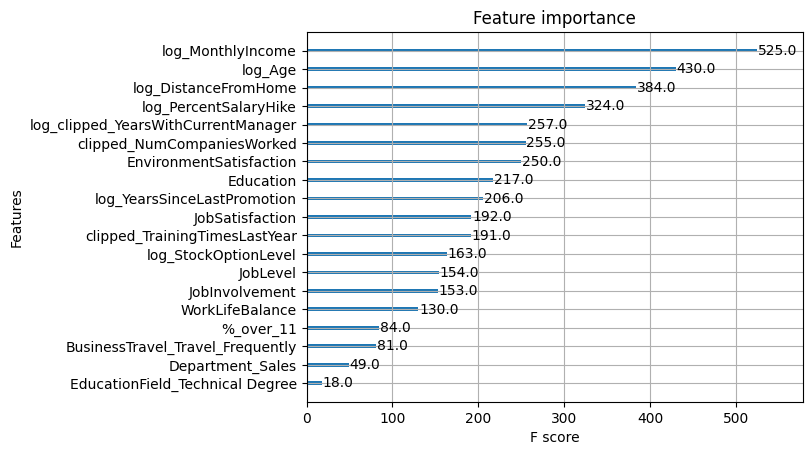

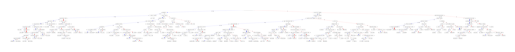

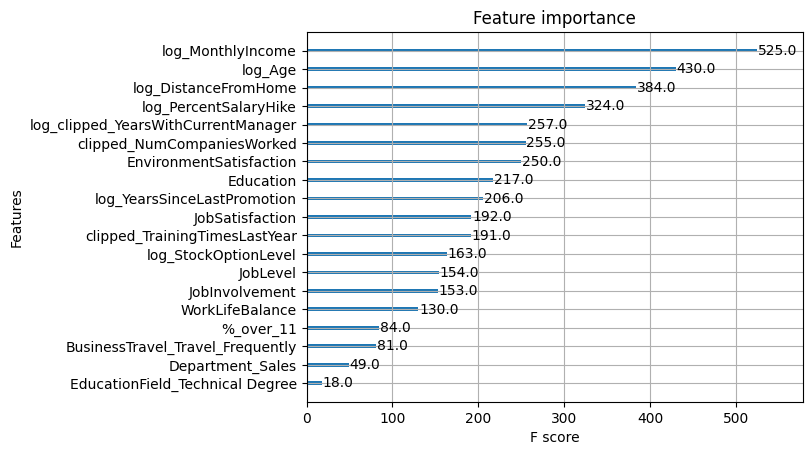

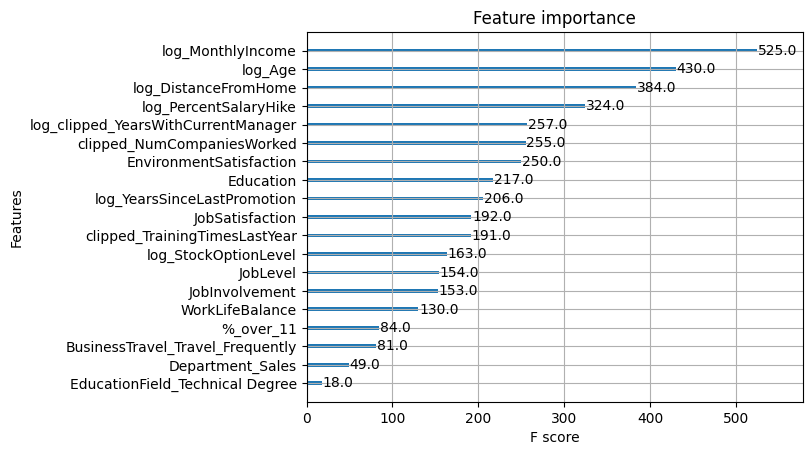

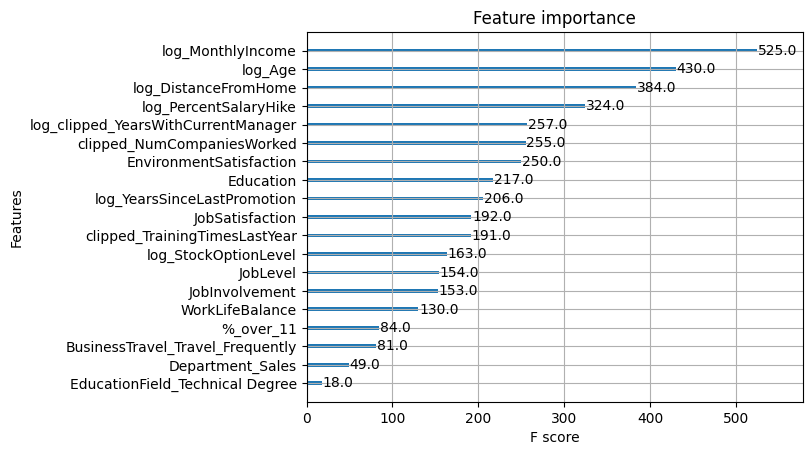

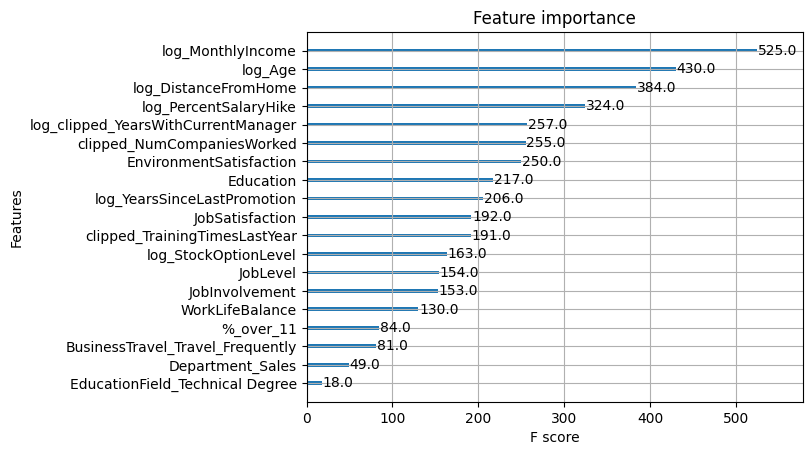

In [38]:
%matplotlib inline

xgb.plot_importance(xgb_model)

<Axes: >

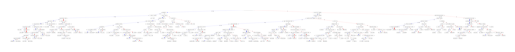

In [39]:
%matplotlib inline

xgb.plot_tree(xgb_model, num_trees=2)